In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c sartorius-cell-instance-segmentation

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!kaggle datasets download -d ammarnassanalhajali/crossvalidationfold5

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip /content/crossvalidationfold5.zip

unzip:  cannot find or open /content/crossvalidationfold5.zip, /content/crossvalidationfold5.zip.zip or /content/crossvalidationfold5.zip.ZIP.


In [ ]:
!unzip /content/sartorius-cell-instance-segmentation.zip

unzip:  cannot find or open /content/sartorius-cell-instance-segmentation.zip, /content/sartorius-cell-instance-segmentation.zip.zip or /content/sartorius-cell-instance-segmentation.zip.ZIP.


In [ ]:
# Install pycocotools
!pip install pycocotools

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-2p8iq9je
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-2p8iq9je
     |████████████████████████████████| 50 kB 1.8 MB/s 
     |████████████████████████████████| 74 kB 3.9 MB/s 
     |████████████████████████████████| 147 kB 49.4 MB/s 
     |████████████████████████████████| 130 kB 49.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 749 kB 45.3 MB/s 
     |████████████████████████████████| 843 kB 52.3 MB/s 
     |████████████████████████████████| 596 kB 10.9 MB/s 
     |████████████████████████████████| 112 kB 60.5 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5284358 sha256=1a1db5422bd169a754c032eb1d94c711dbe46b3f089e8b88d8a8e25bd1b1ca7c
  Stored in directory: /tmp/pip-ephem-wheel-cache-h2b477cc/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7

In [ ]:
import os
import copy
import pickle
import argparse
import json
import random
import sys
import time
import datetime
import logging
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import pandas as pd
import numpy as np

from PIL import Image
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold

import torch
from detectron2 import model_zoo
from detectron2.structures import BoxMode
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator, PascalVOCDetectionEvaluator
from detectron2.config import CfgNode as CN
from detectron2.config import get_cfg
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.logger import setup_logger, log_every_n_seconds
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine.hooks import HookBase
import detectron2.utils.comm as comm
from detectron2.data.datasets import register_coco_instances

from pycocotools import mask as maskUtils

In [ ]:
cfgDict = {
    "dicomPath": None,
    "orgDataPath": "/content/",
    "trainJsonPath": "/content/coco_cell_train_fold3.json",
    "validJsonPath": "/content/coco_cell_valid_fold3.json",
    "newDataPath": None,
    "cachePath": "./",
    "trainDataName": "sartoriusTrain",
    "validDataName": "sartoriusValid",
    "sampleSize": 1000,
    "imSize": None,
    "modelName": "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
    "mask_format": "bitmask",
    "debug": False,
    "outdir": "./results/",
    "logFile": "log.txt",
    "splitMode": True,
    "seed": 111,
    "device": "cuda",
    "iter": 1000,
    "ims_per_batch": 8,
    "roi_batch_size_per_image": 128,
    "eval_period": 50,
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.001,
    "checkpoint_period":500,
    "num_workers": 2,
    "score_thresh_test": 0.5,
    "augKwargs": {
        "RandomFlip": {"prob": 0.5},
        "RandomRotation": {"angle": [0,360]}
    }
}

setup_logger(os.path.join(cfgDict["outdir"],cfgDict["logFile"]))

<Logger detectron2 (DEBUG)>

***RLE*** is a simple method of compressing data by specifying the number of times a character or pixel colour repeats followed by the value of the character or pixel. The aim is to reduce the number of bits used to represent a set of data.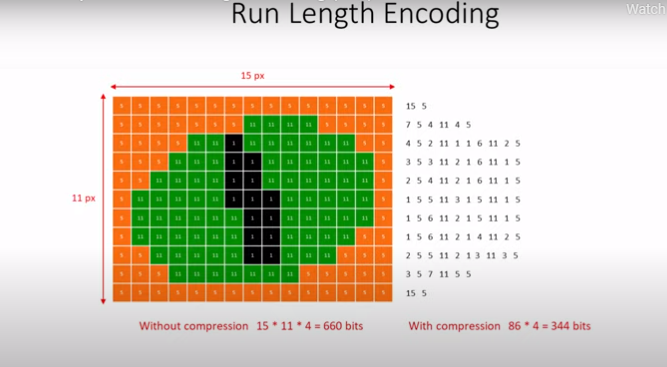

In [ ]:
# Decode rle to binary mask
def rle2mask(rle,h,w):
      '''
    rle: run-length encoded image mask, as string
    h,w: (height, width) of image on which RLE was produced
    Returns (x0, y0, x1, y1) tuple describing the bounding box of the rle mask

    Note on image vs np.array dimensions:

        np.array implies the `[y, x]` indexing order in terms of image dimensions,
        so the variable on `shape[0]` is `y`, and the variable on the `shape[1]` is `x`,
        hence the result would be correct (x0,y0,x1,y1) in terms of image dimensions
        for RLE-encoded indices of np.array (which are produced by widely used kernels
        and are used in most kaggle competitions datasets)
    '''
    # Reshape rle to (2, N) where 2 is for start and length
    rleArray = np.fromiter(rle.split(), dtype = np.uint) #List 2 Array
    rleArray = rleArray.reshape((-1,2)).T #array.T returns the transposed array.
    rleArray[0] = rleArray[0] - 1
    # Decompress the rle length (eg, [3, 1, 10, 2] to [3, 4, 10, 11, 12]
    starts, lenghts = rleArray
    rleArray = np.concatenate([np.arange(s, s + l, dtype = np.uint)
                                        for s, l in zip(starts, lenghts)])
    # Create the binary mask
    mask = np.zeros(h*w, dtype = np.uint8)
    mask[rleArray] = 1
    mask = mask.reshape((h,w))
    # Convert to obj that pycocotools can handle
    mask = np.asfortranarray(mask)
    '''haw chta3ml asfortranarray
    Input  list :  [1, 3, 5, 7, 9]
    output fortanarray from input list :  [1 3 5 7 9]
    '''

    return mask

IndentationError: ignored

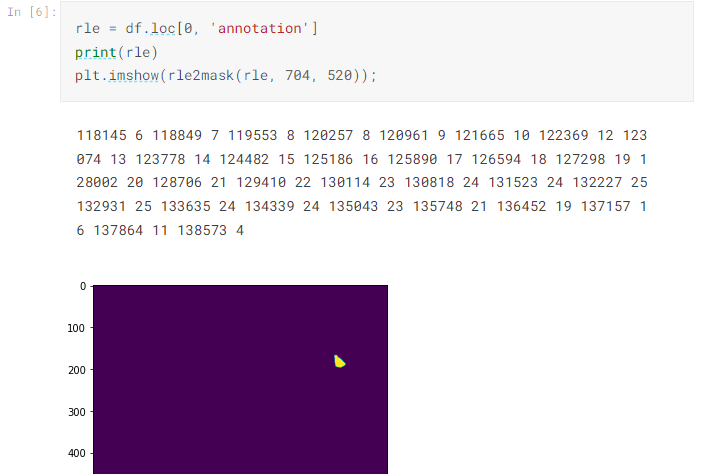

In [ ]:
# Encode the binary mask to COCO annotation with rle
def mask2annotation(idx, row, catIds):
    # rle to binary mask
    mask = rle2mask(row['annotation'],row['height'],row['width'])
    # Encode to rle (coco format)
    rle = maskUtils.encode(mask)
    # Convert from binary to utf-8
    rle['counts'] = rle['counts'].decode('utf-8')
    # Calculate the area
    area = maskUtils.area(rle).item()
    # Calculate the bboxes
    bbox = maskUtils.toBbox(rle).astype(int).tolist()
    # Create COCO annotation
    annotation = {  'segmentation': rle,
                    'bbox': bbox,
                    'area': area,
                    'image_id':row['id'],
                    'category_id':catIds[row['cell_type']],
                    'iscrowd': 0,
                    'id': idx }

    return annotation

COCO Format for Panoptic Segmentation <br/>
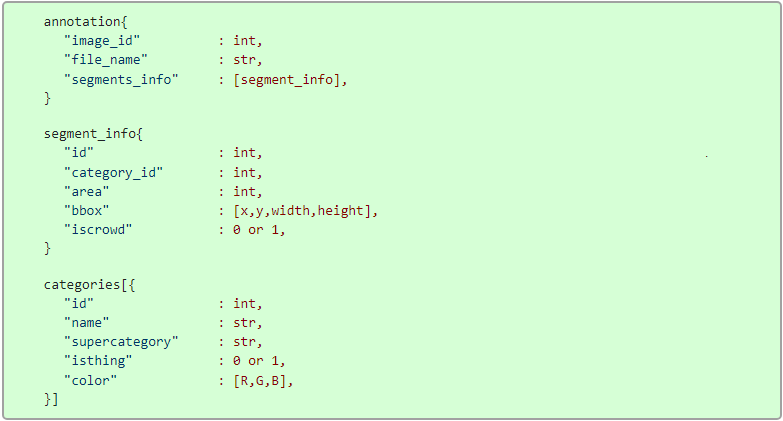

In [ ]:
# Create COCO format JSON
def df2COCO(cfg,df,workers=4):
    # Build header
    catIds = {name:id+1 for id, name in enumerate(df.cell_type.unique())}
    cats =[{'name':name, 'id':id} for name,id in catIds.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height,
               'file_name': f'train/{id}.png'}
              for id,row in df.groupby('id').agg('first').iterrows()]

    # Build annotations
    annotations = Parallel(n_jobs=workers)(delayed(mask2annotation)(idx, row, catIds)
                                           for idx, row in tqdm(df.iterrows(), total = len(df)))
    #This object uses workers to compute in parallel the application of a function to many different arguments.
    return {'categories':cats, 'images':images, 'annotations':annotations}

A simple example of using Joblib.Parallel <br/>
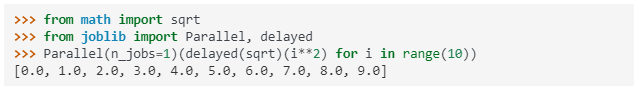

In [ ]:
# Save to json
df = pd.read_csv(os.path.join(cfgDict["orgDataPath"],"train.csv"))
df.head()
root = df2COCO(cfgDict,df[:cfgDict["sampleSize"]])
with open('annotations_train.json', 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4) #we are creating JSON file the output of the df2COCO fnction

In [ ]:
class AugMapper:
    """Custom mapper class for augmentations"""

    def __init__(self, cfg, isTrain=True):
        augKwargs = cfg["augKwargs"]
        augList = []
        # Define a sequence of augmentations
        if isTrain:
            augList.extend([getattr(T, name)(**kwargs) for name, kwargs in augKwargs.items()])
        self.augmentations = T.AugmentationList(augList)
        self.isTrain = isTrain
        self.cfg = cfg

    def __call__(self, datasetDict):
        datasetDict = copy.deepcopy(datasetDict)  # it will be modified by code below
        image = utils.read_image(datasetDict["file_name"], format="BGR")
        augInput = T.AugInput(image) # the augmentation input
        transforms = self.augmentations(augInput) # apply the augmentation
        image = augInput.image # new image
        imShape = image.shape[:2]  # h, w
        datasetDict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32")) # HWC to CHW
        annos = [ utils.transform_instance_annotations(annotation, transforms, imShape)
                    for annotation in datasetDict.pop("annotations")
                    if annotation.get("iscrowd", 0) == 0 ] # apply the augmentation to annotation
        instances = utils.annotations_to_instances(annos,imShape,mask_format=self.cfg.INPUT.MASK_FORMAT)
        datasetDict["instances"] = utils.filter_empty_instances(instances)

        return datasetDict

In [ ]:
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        comm.synchronize()

        return mean_loss

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced


    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            self.trainer.storage.put_scalars(validation_loss=mean_loss)
            print("validation do loss eval", mean_loss)

In [ ]:
class MyTrainer(DefaultTrainer):
    """Overwrite DefaultTrainer methods"""

    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=AugMapper(cfg, True), sampler=sampler
        )

    @classmethod
    def build_test_loader(cls, cfg, datasetName):
        return build_detection_test_loader(
            cfg, datasetName, mapper=AugMapper(cfg, False)
        )

    @classmethodone):
        if outputFolder is None:
    def build_evaluator(cls, cfg, datasetName, outputFolder=N
            outputFolder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(datasetName, ("bbox",), False, output_dir=outputFolder)

    def build_hooks(self):
        hooks = super(MyTrainer, self).build_hooks()
        cfg = self.cfg
        if len(cfg.DATASETS.TEST) > 0:
            loss_eval_hook = LossEvalHook(
                cfg.TEST.EVAL_PERIOD,
                self.model,
                MyTrainer.build_test_loader(cfg, cfg.DATASETS.TEST[0]),
            )
            hooks.insert(-1, loss_eval_hook)

        return hooks

**register_coco_instances** easy way to register your datasets If your instance-level (detection, segmentation, keypoint) dataset is already a json file in the COCO format <br/>
**DatasetCatalog** is A global dictionary that stores information about the datasets and how to obtain them. <br/>
**Metadata** is a key-value mapping that contains information that’s shared among the entire dataset, and usually is used to interpret what’s in the dataset, e.g., names of classes, colors of classes, root of files, etc.

In [ ]:
DatasetCatalog.clear()
register_coco_instances(cfgDict["trainDataName"],{},cfgDict["trainJsonPath"],cfgDict["orgDataPath"])
register_coco_instances(cfgDict["validDataName"],{},cfgDict["validJsonPath"],cfgDict["orgDataPath"])

metadata = MetadataCatalog.get(cfgDict["trainDataName"])
datasetTrain = DatasetCatalog.get(cfgDict["trainDataName"])
datasetValid = DatasetCatalog.get(cfgDict["validDataName"])

In [ ]:
d = datasetTrain[0]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1, instance_mode=ColorMode.IMAGE_BW)
out = visualizer.draw_dataset_dict(d)
Image.fromarray(out.get_image()[:, :, ::-1])

In [ ]:
cfg = get_cfg() #Get a copy of the default config.

cfg.augKwargs = CN(cfgDict["augKwargs"])  # pass augKwargs to cfg as a CN
cfg.merge_from_file(model_zoo.get_config_file(cfgDict["modelName"]))
cfg.MODEL.DEVICE = cfgDict["device"]
cfg.OUTPUT_DIR = cfgDict["outdir"]
cfg.DATASETS.TRAIN = (cfgDict["trainDataName"],)
if cfgDict["splitMode"] is None:
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = (cfgDict["validDataName"],)
    cfg.TEST.EVAL_PERIOD = cfgDict["eval_period"]
cfg.DATALOADER.NUM_WORKERS = cfgDict["num_workers"] #number of parallel data loading workers
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfgDict["modelName"])
cfg.SOLVER.IMS_PER_BATCH = cfgDict["ims_per_batch"]
cfg.SOLVER.LR_SCHEDULER_NAME = cfgDict["lr_scheduler_name"]
cfg.SOLVER.BASE_LR = cfgDict["base_lr"]
cfg.SOLVER.MAX_ITER = cfgDict["iter"]
cfg.SOLVER.CHECKPOINT_PERIOD = cfgDict["checkpoint_period"]
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = cfgDict["roi_batch_size_per_image"]
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(metadata.get("thing_classes"))
cfg.INPUT.MASK_FORMAT = cfgDict["mask_format"]
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = cfgDict["score_thresh_test"]

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
dfMetrics = pd.read_json(os.path.join(cfgDict["outdir"],"metrics.json"), orient="records", lines=True)
dfMetrics = dfMetrics.sort_values("iteration")
dfMetrics.head()

In [ ]:
dfTrainLoss = dfMetrics[~dfMetrics["total_loss"].isna()]
plt.plot(dfTrainLoss["iteration"], dfTrainLoss["total_loss"], c="C0", label="train")
if "validation_loss" in dfMetrics.columns:
    dfValidLoss = dfMetrics[~dfMetrics["validation_loss"].isna()]
    plt.plot(dfValidLoss["iteration"], dfValidLoss["validation_loss"], c="C1", label="validation")

plt.legend()
plt.title("Loss curve")
plt.xlabel("Iteration")
plt.show()

In [ ]:
# Same cfg from trainer and use the final model output to initialize the predictor
cfg.MODEL.WEIGHTS = os.path.join(cfgDict["outdir"],"model_final.pth")
predictor = DefaultPredictor(cfg)

d = datasetTrain[3]
im = cv2.imread(d["file_name"])
if predictor.input_format == "RGB":
    im = im[:, :, ::-1]
height, width = im.shape[:2]
image = torch.as_tensor(im.astype("float32").transpose(2, 0, 1))
inputs = [{"image": image, "height": height, "width": width}]
outputs = predictor.model(inputs)
output = outputs[0]

visualizer = Visualizer(im,metadata=metadata, scale=1, instance_mode=ColorMode.IMAGE_BW)
out = visualizer.draw_instance_predictions(output["instances"].to("cpu"))
Image.fromarray(out.get_image()[:, :, ::-1])

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output